## **ATOC4500 Data Science Lab: Final Project**
## **Using rapid ice loss events to predict when CESM1 ensemble members go ice free**
#### **Author: Daphne Quint, daqu2831@colorado.edu**
#### **Last updated: April 14, 2022**

---------------------------------------------------------------------------------------

### Import packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import datetime
import time

### Define functions

In [2]:
def find_year(data, member):
    '''
    Finds the year 1 member goes below 1 million square km
    '''
    
    data_ = data.sel(member=member)
    
    year = 2020
    for i in data_:
        if i>1:
            year += 1
        else:
            return year

In [3]:
def create_df(month, model_name, num_mems):
    # select correct data
    if model_name == 'MPI_ESM1':
        nb_ext_data = nb_ext_data_MPI
        length_data = length_data_MPI
    else:
        nb_ext_data = nb_ext_data_CESM
        length_data = length_data_CESM
    
    #### find ice free year for that month
    
    ###first find 5 year mean
    
    # define September SIE
    SIE_sept = SIE[model_name].sel(time=SIE['time.month']==month).sel(member=np.arange(1, num_mems+1, 1))

    # find the 5 year running mean
    five_year_mean = SIE_sept*0

    for i in range(1, num_mems+1):
        five_year_mean[i-1] = SIE_sept.sel(member=i).rolling(time=5).mean()

    five_year_mean = five_year_mean.sel(time=slice('2020', '2100'))
    
    ### then find the ice free year
    ice_free_year = []
    for i in range(1, num_mems+1):
        ice_free_year.append(find_year(five_year_mean, i))
    ice_free_year = np.array(ice_free_year)
    
    #### find max amt of ice lost in the month
    
    ice_lost_max = []
    for i in range(1, num_mems+1):
        ice_lost_max.append(float(nb_ext_data['RILE Indicator'].sel(member=i).sel(month=month).min().values))
    ice_lost_max = np.array(ice_lost_max)
    
    #### find longest duration for the month
    
    length_max = []
    for i in range(1, num_mems+1):
        length_max.append(float(length_data['Length'].sel(member=i).sel(month=month).max().values))
    length_max = np.array(length_max)
    
    #### create dataframe
    
    member = pd.DataFrame(data=np.arange(1, num_mems+1), columns=['Member'])
    month = pd.DataFrame(data=(np.zeros(num_mems)+month), columns=['Month'])
    ice_free_yr_df = pd.DataFrame(data=ice_free_year, columns=['Ice Free Year'])
    ice_lost_max_df = pd.DataFrame(data=ice_lost_max, columns=['Max Ice Lost'])*-1
    length_max_df = pd.DataFrame(data=length_max, columns=['Longest Duration'])
    
    this_month_df = pd.concat([member, month, ice_free_yr_df, ice_lost_max_df, length_max_df], axis=1)
    
    return this_month_df

In [4]:
def define_holdout_data(x, y, verbose):
    """Perform a 80/20 test-train split (80% of data is training, 20% is testing). Split is randomized with each call."""
    random_state = randint(0,1000)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=random_state)
    if verbose==True:
        print("Prior to scaling and rebalacing...")
        print("Shape of training predictors: "+str(np.shape(x_train)))
        print("Shape of testing predictors: "+str(np.shape(x_test)))
        print("Shape of training predictands: "+str(np.shape(y_train)))
        print("Shape of testing predictands: "+str(np.shape(y_test)))
        print(" ")
    return x_train, x_test, y_train, y_test

In [5]:
def scale_data(x_train, x_test):
    """
    Scale training data so that model reaches optimized weights much faster. 
    
    *All data that enters the model should use the same scaling used to scale the training data.*
    Thus, we also perform scaling on testing data for validation later. 
    Additionally, we return the scaler used to scale any other future input data.
    """
    
    scaler = preprocessing.MinMaxScaler() # normalize 
    x_train_scaled = pd.DataFrame(data=scaler.fit_transform(x_train),index=x_train.index,columns=x_train.columns) 
    x_test_scaled = pd.DataFrame(data=scaler.transform(x_test),index=x_test.index,columns=x_test.columns)
    
    return scaler, x_train_scaled, x_test_scaled

In [6]:
def balance_data(x,y,verbose):
    """Resample data ensure model is not biased towards a particular outcome of precip or no precip."""
    # Combine again to one dataframe to ensure both the predictor and predictand are resampled from the same 
    # observations based on predictand outcomes. 
    dataset = pd.concat([x, y],axis=1)

    # Separating classes
    early = dataset[dataset['early_bin'] == 1]
    not_early = dataset[dataset['early_bin'] == 0]

    random_state = randint(0,1000)
    oversample = resample(early, 
                           replace=True, 
                           n_samples=len(not_early), #set the number of samples to equal the number of the majority class
                           random_state=random_state)

    # Returning to new training set
    oversample_dataset = pd.concat([not_early, oversample])

    # reseparate oversampled data into X and y sets
    x_bal = oversample_dataset.drop(['early_bin'], axis=1)
    y_bal = oversample_dataset['early_bin']

    if verbose==True:
        print("After scaling and rebalacing...")
        print("Shape of predictors: "+str(np.shape(x_bal)))
        print("Shape of predictands: "+str(np.shape(y_bal)))
        print(" ")
    
    return x_bal, y_bal

In [7]:
def dataprep_pipeline(x, y, verbose):
    """ Combines all the functions defined above so that the user only has to 
    call one function to do all data pre-processing. """
    # verbose=True prints the shapes of input & output data

    # split into training & testing data
    x_train, x_test, y_train, y_test = define_holdout_data(x, y, verbose) 

    # perform feature scaling
    scaler, x_train_scaled, x_test_scaled = scale_data(x_train, x_test)

    # rebalance according to outcomes (i.e., the number of precipitating 
    # observations & non-precipitating outcomes should be equal)
    if verbose==True:
        print("for training data... ")
    x_train_bal, y_train_bal = balance_data(x_train_scaled, y_train, verbose)
    if verbose==True:
        print("for testing data... ")
    x_test_bal, y_test_bal = balance_data(x_test_scaled, y_test, verbose)
    
    return x_train_bal, y_train_bal, x_test_bal, y_test_bal

In [8]:
def bin_metrics(x, y):
    """Prints accuracy and recall metrics for evaluating 
    classification predictions."""
    
    accuracy = metrics.accuracy_score(x, y)
    recall = metrics.recall_score(x, y)

    print('Accuracy:', round(accuracy, 4))
    print('Recall:', round(recall, 4))
    
    return accuracy, recall

In [9]:
def plot_cm(x, y):
    """Plots the confusion matrix to visualize true 
    & false positives & negatives"""
    cm = confusion_matrix(x, y)
    df_cm = pd.DataFrame(cm, columns=np.unique(x), index = np.unique(x))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25}, fmt='g')# font size
    plt.ylim([0, 2])
    plt.xticks([0.5, 1.5], ['Negatives','Positives'])
    plt.yticks([0.5, 1.5], ['Negatives','Positives'])

In [10]:
def rand_atmos_conditions_precip(index='rand'):
    """
    Function returns atmospheric conditions in a dataframe as well as the scaled
    conditions in a numpy array so that they output a prediction in the model.
    
    If no input is passed, the function will randomly generate an in index to 
    choose from those observations in some training data with precipitation. 
    Otherwise, an integer index between 0 and 200 should be passed.
    """
    # First, perform a test-train split
    x_train, x_test, y_train, _ = define_holdout_data(x, y, verbose=False) 

    # perform feature scaling
    _, x_train_scaled, _ = scale_data(x_train, x_test)

    # this is what will go into the model to output a prediction
    if index=='rand':
        index = randint(0,len(y_train[y_train==1].index)) 
    precipindex = y_train[y_train==1].index.values[index]
    testpredictor = x_train_scaled.loc[precipindex] 
    
    return sept_df.iloc[precipindex], testpredictor 

## Step 1: Read in Data

In [11]:
data_path = '/home/daphne/Documents/School/research/icefreeproject/Data/'

# Amount of sea ice lost and Sea ice extent data for each RILE
nb_ext_data_CESM = xr.open_dataset(data_path+'RILE_nbext_CESM.nc')
nb_ext_data_MPI = xr.open_dataset(data_path+'RILE_nbext_MPI.nc')

# length data (consecutive years in a row there is a rile for that month)
length_data_CESM = xr.open_dataset(data_path+'CESM_rile_length.nc')
length_data_MPI = xr.open_dataset(data_path+'MPI_rile_length.nc')

# extent data - can be used to find ice free year for each member
SIE = xr.open_dataset(data_path+'CLIVAR_SIE_1850_2100_RCP85.nc')

## Step 2: Munge Data

In [12]:
# create dataframe for CESM
CESM_sept_df = create_df(9, 'CESM1', 40)

In [13]:
# create dataframe for MPI
MPI_sept_df = create_df(9, 'MPI_ESM1', 100)

# add 40 to MPI members so they are distinct from CESM members
MPI_sept_df.Member = MPI_sept_df.Member + 40

In [14]:
# concatenate the two dataframes to create a 'megamodel'
sept_df = pd.concat([CESM_sept_df, MPI_sept_df], ignore_index=True, sort=False)

In [15]:
# check to see if there are nan values
print(np.any(np.isnan(sept_df)))

# drop nan values so they don't mess up the data science method
sept_df = sept_df.dropna()

True


## Step 3: Apply Data Science Method

### Logistic Regression

In [16]:
# select a year to separate the ice free column into 2 groups
ify_mean = sept_df['Ice Free Year'].mean()
ify_std  = sept_df['Ice Free Year'].std()
split_yr = ify_mean - (1.5*ify_std)
print(split_yr)

2045.970304392289


In [17]:
# create a feature that indicates whether or not the member goes ice free before 2046
sept_df['early_bin'] = np.array(sept_df['Ice Free Year']<=2046).astype(int)

In [18]:
# features that we will use to predict ice free year
x = sept_df.drop(['Month','Member', 'Ice Free Year', 'early_bin'],axis=1)

# what we are trying to predict- early ice free year
y = sept_df.drop(['Month','Member', 'Longest Duration', 'Max Ice Lost', 'Ice Free Year'], axis=1)

In [19]:
# check to see if the results are balanced
y.value_counts()

early_bin
0            119
1             16
dtype: int64

In [20]:
# Perform a test-train split, perform feature scaling, and the rebalance our dataset
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=True)

Prior to scaling and rebalacing...
Shape of training predictors: (108, 2)
Shape of testing predictors: (27, 2)
Shape of training predictands: (108, 1)
Shape of testing predictands: (27, 1)
 
for training data... 
After scaling and rebalacing...
Shape of predictors: (188, 2)
Shape of predictands: (188,)
 
for testing data... 
After scaling and rebalacing...
Shape of predictors: (50, 2)
Shape of predictands: (50,)
 


In [21]:
# initialize the logistic regression model
lr = LogisticRegression(solver='lbfgs')

# fit the model to scaled & balanced training data
lr.fit(x_train_bal, y_train_bal);

Accuracy: 0.8
Recall: 1.0


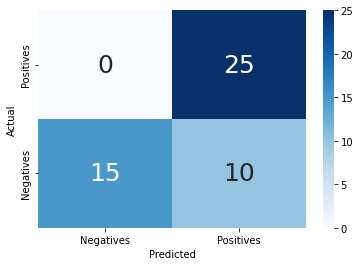

In [22]:
# use the test data - data not used for the logistic regression - to see how well the model does
y_pred = lr.predict(x_test_bal)

plot_cm(y_test_bal, y_pred);
lr_acc, lr_rec = bin_metrics(y_test_bal, y_pred)

In [23]:
# check to see if the the logistic regression is overfitting or underfitting

# Compare testing data metrics to data training metrics
print("Training metrics:")
pred_train= lr.predict(x_train_bal) 
bin_metrics(y_train_bal,pred_train);

# As a reminder, display testing metrics
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, y_pred);

Training metrics:
Accuracy: 0.6543
Recall: 0.5851
 
Testing metrics:
Accuracy: 0.8
Recall: 1.0


Since testing metric is slightly less than the training metric, we may be overfitting, i.e, the model is too complex

In [24]:
# Make a prediction with the Logistic Regression model
    # randomly choose some conditions using the rand_atmos_conditions function
origvals, testpredictor = rand_atmos_conditions_precip()

print(origvals) # observation from original dataframe
print("")
print(testpredictor) # scaled observation

Member                96.000000
Month                  9.000000
Ice Free Year       2060.000000
Max Ice Lost           0.367144
Longest Duration       7.000000
early_bin              0.000000
Name: 95, dtype: float64

Max Ice Lost        0.231393
Longest Duration    0.250000
Name: 92, dtype: float64


In [25]:
lr_prediction = lr.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The conditions are: ")
print(origvals)
print(" ")
print("There is a {0:.{digits}f}% chance a member will go ice free in 2046 or before given those conditions.".format(lr_prediction, digits=2))

The conditions are: 
Member                96.000000
Month                  9.000000
Ice Free Year       2060.000000
Max Ice Lost           0.367144
Longest Duration       7.000000
early_bin              0.000000
Name: 95, dtype: float64
 
There is a 49.09% chance a member will go ice free in 2046 or before given those conditions.


/home/daphne/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Random Forest

In [26]:
# Perform a test-train split, perform feature scaling, and the rebalance our dataset
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=False)

In [27]:
# train and tune the random forest model

# choose the hyperparameters
    # choose to adjust the number of estimators in the forest and the depth of the tree
    
acc_scores = []
rec_scores = []

num_est = [10, 50, 500] # number of trees
depth = [2, 10, 100] # number of decisions
for i in num_est:
    start = time.time()
    print("Number of estimators is "+str(i))

    for k in depth:
        print("depth is "+str(k))
        forest = RandomForestClassifier(n_estimators=i, max_depth=k)
        forest.fit(x_train_bal, y_train_bal)
        
        # cross validate & evaluate metrics based on testing data
        pred_test= forest.predict(x_test_bal)
        acc_val = metrics.accuracy_score(y_test_bal, pred_test)
        acc_scores.append(acc_val)
        rec_val = metrics.recall_score(y_test_bal, pred_test)
        rec_scores.append(rec_val)

    end = time.time()
    print("Random Forest took "+str(end-start)+" seconds.")

Number of estimators is 10
depth is 2
depth is 10
depth is 100
Random Forest took 0.0334627628326416 seconds.
Number of estimators is 50
depth is 2
depth is 10
depth is 100
Random Forest took 0.10330367088317871 seconds.
Number of estimators is 500
depth is 2
depth is 10
depth is 100
Random Forest took 0.8735697269439697 seconds.


Max Accuracy (black): 0.6667
Max Recall (blue): 0.5


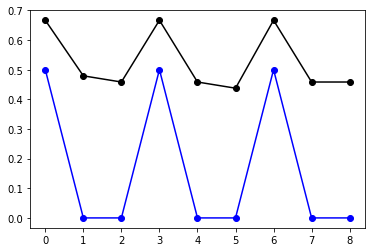

In [28]:
plt.plot(acc_scores, marker='o', color='black')
plt.plot(rec_scores, marker='o', color='blue')
print("Max Accuracy (black):", round(max(acc_scores), 4))
print("Max Recall (blue):", round(max(rec_scores), 4))

In [30]:
# hyper parameter selection - choose x=0 for maximum accuracy and recall
forest = RandomForestClassifier(n_estimators=10, max_depth=2);
forest.fit(x_train_bal, y_train_bal);

Accuracy: 0.6875
Recall: 0.5


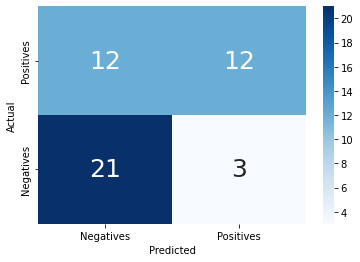

In [31]:
# Assess the Random Forest's performance using testing data
pred_test= forest.predict(x_test_bal)

# Calculate metrics & plot a confusion matrix based on how well model simulates testing data
forest_acc, forest_rec = bin_metrics(y_test_bal, pred_test)

#plot
plot_cm(y_test_bal, pred_test)

In [32]:
#Check to see if the Random Forest is overfitting

# Compare testing data metrics to data training metrics.
print("Training metrics:")
rf_pred_train= forest.predict(x_train_bal) 
bin_metrics(y_train_bal,rf_pred_train);

# display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, pred_test);

Training metrics:
Accuracy: 0.6947
Recall: 0.4842
 
Testing metrics:
Accuracy: 0.6875
Recall: 0.5


Testing accuracy is slightly less than the training data, while the recall is greater which may indicate overfitting

In [33]:
# Make a prediction with the Random Forest

# prediction output is in the format [probability not before 2046, probability before 2046]
forest_prediction = forest.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The conditions are: ")
print(origvals)
print(" ")
print("There is a {0:.{digits}f}% chance that a member will go ice free in 2046 or before given those conditions.".format(forest_prediction, digits=2))

The conditions are: 
Member                96.000000
Month                  9.000000
Ice Free Year       2060.000000
Max Ice Lost           0.367144
Longest Duration       7.000000
early_bin              0.000000
Name: 95, dtype: float64
 
There is a 46.68% chance that a member will go ice free in 2046 or before given those conditions.


/home/daphne/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [34]:
model_metrics = pd.DataFrame({'Metrics':['Accuracy','Recall','Prediction example'],
     'Logistic Regression':[lr_acc, lr_rec, lr_prediction],
    'Random Forest':[forest_acc, forest_rec, forest_prediction]})
model_metrics = model_metrics.set_index('Metrics')
model_metrics

,Logistic Regression,Random Forest
Metrics,,
Accuracy,0.800000,0.687500
Recall,1.000000,0.500000
Prediction example,49.094812,46.683783


## Step 4: Present graphs visually using 2-3 graphs

## Summary